In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import stats
import statsmodels.api as sm


In [44]:
# config
FEAR_GREED_PATH = "fear_greed_index.csv"
TRADES_PATH     = "historical_data.csv"
OUTPUT_DIR      = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [46]:
fg = pd.read_csv(FEAR_GREED_PATH)

# columns normalize
fg.columns = [c.strip().lower().replace(" ", "_") for c in fg.columns]

# date parse
fg["date"] = pd.to_datetime(fg["date"], errors="coerce").dt.date



In [49]:
# classification ko normalize
fg["classification"] = fg["classification"].str.upper().str.strip()
fg["classification"] = fg["classification"].replace({
    "EXTREME GREED": "GREED",
    "GREED": "GREED",
    "EXTREME FEAR": "FEAR",
    "FEAR": "FEAR"
})

# flag
fg["is_greed"] = (fg["classification"] == "GREED").astype(int)


In [51]:


tr = pd.read_csv("historical_data.csv")  # file ka path correct hona chahiye
print(tr.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [53]:
# Hyperliquid trades load & clean

tr = pd.read_csv(TRADES_PATH)

# normalize columns
tr.columns = [c.strip().lower().replace(" ", "_") for c in tr.columns]

In [55]:
# rename important fields
rename_map = {
    "time": "time", 
    "timestamp_ist": "time",   # tumhare dataset me time IST format me hai
    "side": "side",
    "price": "price",
    "size_usd": "size",        # tumhare dataset me ye hai
    "closed_pnl": "pnl",       # profit/loss column fix
    "start_position": "start_position",
    "coin": "symbol",
    "account": "account"
}

In [57]:
for k, v in rename_map.items():
    if k in tr.columns:
        tr.rename(columns={k: v}, inplace=True)

# safe time/date parsing
if "time" in tr.columns:
    tr["time"] = pd.to_datetime(tr["time"], errors="coerce", utc=True)

if "date" in tr.columns:
    tr["date"] = pd.to_datetime(tr["date"], errors="coerce").dt.date
else:
    tr["date"] = tr["time"].dt.date


In [59]:
# normalize side
tr["side"] = tr["side"].str.upper().str.strip()
tr["side"] = tr["side"].replace({"BUY": "LONG", "SELL": "SHORT"})

# numeric conversion
for col in ["pnl", "size"]:
    if col in tr.columns:
        tr[col] = pd.to_numeric(tr[col], errors="coerce")

# flags
tr["is_long"] = (tr["side"] == "LONG").astype(int)
tr["is_win"] = (tr["pnl"] > 0).astype(int)

In [61]:
print(tr.head())
print(fg.head())


                                      account symbol  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9894   

   size_tokens     size  side                      time  start_position  \
0       986.87  7872.16  LONG 2024-02-12 22:50:00+00:00        0.000000   
1        16.00   127.68  LONG 2024-02-12 22:50:00+00:00      986.524596   
2       144.09  1150.63  LONG 2024-02-12 22:50:00+00:00     1002.518996   
3       142.98  1142.04  LONG 2024-02-12 22:50:00+00:00     1146.558564   
4         8.73    69.75  LONG 2024-02-12 22:50:00+00:00     1289.488521   

  direction  pnl                                   transaction_hash  \
0       Buy  0.0  0xec09451986a1874e3a9

In [63]:
# merge trades with sentiment on 'date'
merged = pd.merge(
    tr, 
    fg[["date", "classification", "is_greed"]], 
    on="date", 
    how="left"
)

# fill unknowns (agar koi trade ka date sentiment dataset me missing ho)
merged["classification"] = merged["classification"].fillna("UNKNOWN")

print(merged.head())


                                      account symbol  execution_price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed   @107           7.9894   

   size_tokens     size  side                      time  start_position  \
0       986.87  7872.16  LONG 2024-02-12 22:50:00+00:00        0.000000   
1        16.00   127.68  LONG 2024-02-12 22:50:00+00:00      986.524596   
2       144.09  1150.63  LONG 2024-02-12 22:50:00+00:00     1002.518996   
3       142.98  1142.04  LONG 2024-02-12 22:50:00+00:00     1146.558564   
4         8.73    69.75  LONG 2024-02-12 22:50:00+00:00     1289.488521   

  direction  pnl  ...     order_id  crossed       fee      trade_id  \
0       Buy  0.0  ...  52017706630     

In [65]:
kpi = merged.groupby("classification").agg(
    trades=("pnl", "count"),
    win_rate=("is_win", "mean"),
    avg_pnl=("pnl", "mean"),
    median_pnl=("pnl", "median"),
    std_pnl=("pnl", "std"),
    avg_size=("size", "mean"),
    long_share=("is_long", "mean")
).reset_index()

print(kpi)

  classification  trades  win_rate     avg_pnl  median_pnl      std_pnl  \
0           FEAR   16195  0.369003  110.134333         0.0  1243.340984   
1          GREED   16913  0.474783  104.447834         0.0  1569.796443   
2        NEUTRAL    2756  0.494920   27.088803         0.0   142.945889   
3        UNKNOWN  175360  0.407727   38.048303         0.0   797.586837   

      avg_size  long_share  
0  5511.246132    0.523310  
1  4450.397683    0.417903  
2  4332.202906    0.370102  
3  5786.517359    0.491178  


In [67]:
side_sent = merged.groupby(["classification", "side"]).agg(
    trades=("pnl", "count"),
    win_rate=("is_win", "mean"),
    avg_pnl=("pnl", "mean")
).reset_index()

print(side_sent)


  classification   side  trades  win_rate     avg_pnl
0           FEAR   LONG    8475  0.300413  180.978355
1           FEAR  SHORT    7720  0.444301   32.361912
2          GREED   LONG    7068  0.300226   14.106952
3          GREED  SHORT    9845  0.600102  169.306071
4        NEUTRAL   LONG    1020  0.326471   12.484274
5        NEUTRAL  SHORT    1736  0.593894   35.669805
6        UNKNOWN   LONG   86133  0.268515   23.934820
7        UNKNOWN  SHORT   89227  0.542112   51.672393


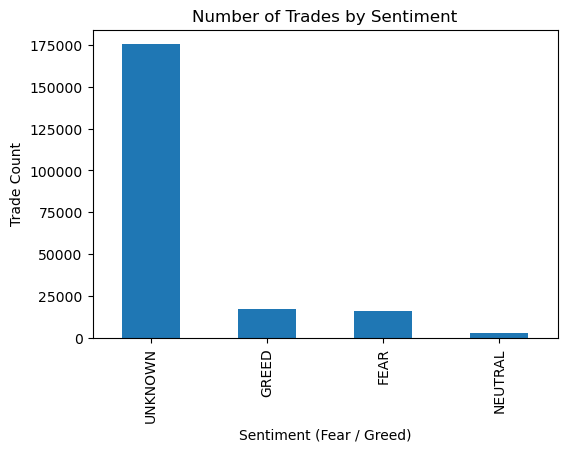

In [69]:
import matplotlib.pyplot as plt

merged["classification"].value_counts().plot(kind="bar", figsize=(6,4))
plt.title("Number of Trades by Sentiment")
plt.xlabel("Sentiment (Fear / Greed)")
plt.ylabel("Trade Count")
plt.show()

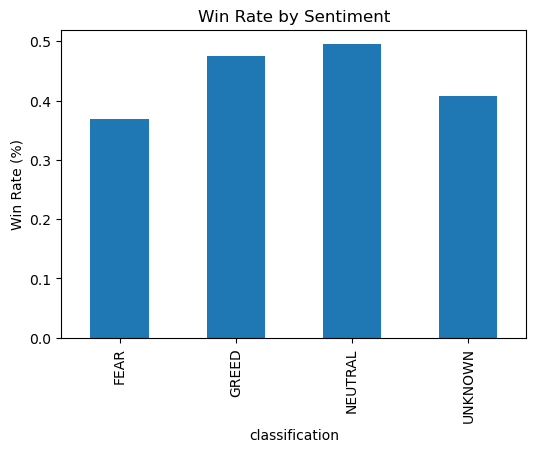

In [71]:
kpi.plot(x="classification", y="win_rate", kind="bar", figsize=(6,4), legend=False)
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate (%)")
plt.show()


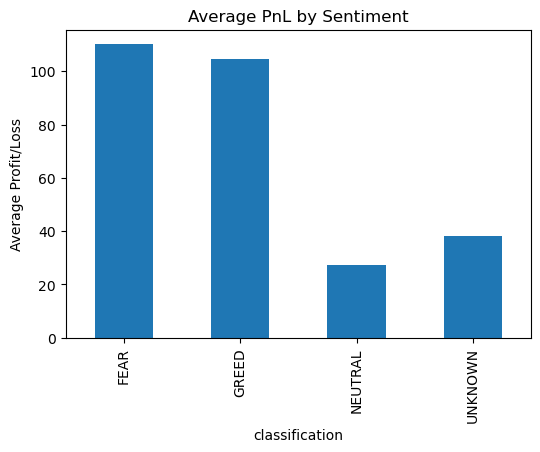

In [73]:
kpi.plot(x="classification", y="avg_pnl", kind="bar", figsize=(6,4), legend=False)
plt.title("Average PnL by Sentiment")
plt.ylabel("Average Profit/Loss")
plt.show()


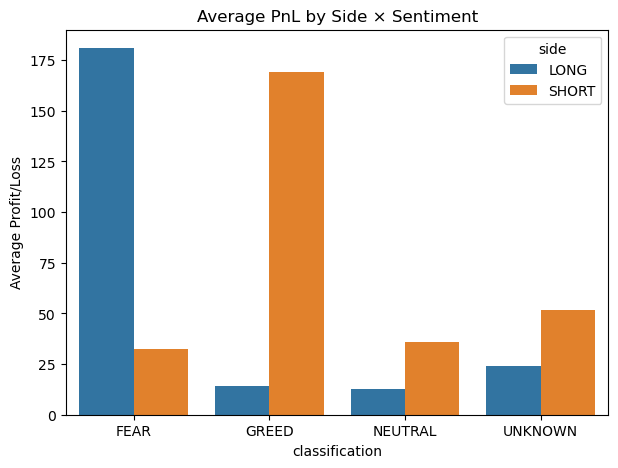

In [75]:
import seaborn as sns

plt.figure(figsize=(7,5))
sns.barplot(data=side_sent, x="classification", y="avg_pnl", hue="side")
plt.title("Average PnL by Side × Sentiment")
plt.ylabel("Average Profit/Loss")
plt.show()

In [77]:
kpi.to_csv("kpi_by_sentiment.csv", index=False)
side_sent.to_csv("kpi_by_side_sentiment.csv", index=False)


In [79]:
merged.to_csv("trades_with_sentiment.csv", index=False)


In [81]:
print(merged.columns.tolist())


['account', 'symbol', 'execution_price', 'size_tokens', 'size', 'side', 'time', 'start_position', 'direction', 'pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp', 'date', 'is_long', 'is_win', 'classification', 'is_greed']


In [83]:
print("=== INSIGHTS REPORT ===")

# 1. Overall PnL performance
overall_pnl = merged["pnl"].mean()
print(f"Average PnL across all trades: {overall_pnl:.2f} USD")


=== INSIGHTS REPORT ===
Average PnL across all trades: 48.75 USD


In [85]:
# 2. Sentiment-wise Win Rate
sentiment_wr = merged.groupby("classification")["is_win"].mean() * 100
print("\nWin Rate by Sentiment:")
print(sentiment_wr)


Win Rate by Sentiment:
classification
FEAR       36.900278
GREED      47.478271
NEUTRAL    49.492017
UNKNOWN    40.772696
Name: is_win, dtype: float64


In [87]:
# 3. Side (LONG/SHORT) performance by sentiment
side_perf = merged.groupby(["classification", "side"])["pnl"].mean()
print("\nAvg PnL by Side and Sentiment:")
print(side_perf)


Avg PnL by Side and Sentiment:
classification  side 
FEAR            LONG     180.978355
                SHORT     32.361912
GREED           LONG      14.106952
                SHORT    169.306071
NEUTRAL         LONG      12.484274
                SHORT     35.669805
UNKNOWN         LONG      23.934820
                SHORT     51.672393
Name: pnl, dtype: float64


In [89]:
# 4. Most favorable sentiment
best_sent = merged.groupby("classification")["pnl"].mean().idxmax()
print(f"\nBest performing sentiment (highest avg pnl): {best_sent}")


Best performing sentiment (highest avg pnl): FEAR


In [91]:
# 5. Most risky sentiment
worst_sent = merged.groupby("classification")["pnl"].mean().idxmin()
print(f"Most risky sentiment (lowest avg pnl): {worst_sent}")


Most risky sentiment (lowest avg pnl): NEUTRAL


In [93]:
with open("traders_insights_report.txt", "w") as f:
    f.write("=== TRADER BEHAVIOR INSIGHTS REPORT ===\n\n")

    # Overall PnL
    overall_pnl = merged["pnl"].mean()
    f.write(f"Average PnL across all trades: {overall_pnl:.2f} USD\n\n")

    # Sentiment-wise Win Rate
    f.write("Win Rate by Sentiment:\n")
    sentiment_wr = merged.groupby("classification")["is_win"].mean() * 100
    f.write(sentiment_wr.to_string() + "\n\n")

    # Side performance
    f.write("Avg PnL by Side and Sentiment:\n")
    side_perf = merged.groupby(["classification", "side"])["pnl"].mean()
    f.write(side_perf.to_string() + "\n\n")

    # Best & Worst sentiment
    best_sent = merged.groupby("classification")["pnl"].mean().idxmax()
    worst_sent = merged.groupby("classification")["pnl"].mean().idxmin()
    f.write(f"Best performing sentiment (highest avg pnl): {best_sent}\n")
    f.write(f"Most risky sentiment (lowest avg pnl): {worst_sent}\n")
